# Part1: Preprossing The Dataset


## Importing Libraries And Loading The Dataset

In [3]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install opendatasets
# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime

from bs4 import BeautifulSoup

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier



In [171]:
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [172]:
od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Skipping, found downloaded files in "data/imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


In [173]:
for dirpath, dirnames ,  filenames in os.walk("/content/data"):
    print(f"there is {len(dirnames)} dirs and {len(filenames)} files in {dirpath}")

there is 1 dirs and 0 files in /content/data
there is 0 dirs and 1 files in /content/data/imdb-dataset-of-50k-movie-reviews


In [174]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

## Exploring The Dataset

In [175]:
df_copy.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [176]:
df_copy.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


I think we have some duplicated reviews in the dataset

In [177]:
df_copy["dub"] = df_copy.duplicated()

In [178]:
df_unique = df_copy[df_copy["dub"] == False]

In [179]:
df_unique.describe()

,review,sentiment,dub
count,49582,49582,49582
unique,49582,2,1
top,One of the other reviewers has mentioned that ...,positive,False
freq,1,24884,49582


In [180]:
df_unique["sentiment"].value_counts(), df_copy["sentiment"].value_counts()

(positive    24884
 negative    24698
 Name: sentiment, dtype: int64, positive    25000
 negative    25000
 Name: sentiment, dtype: int64)

In [181]:
df_copy.groupby("sentiment").count()

,review,dub
sentiment,,
negative,25000,25000
positive,25000,25000


I will work with df_copy because it is balaneced unlike df_unique

### Visualise Some Reviews

In [182]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)



  The Review :
  OK,but does that make this a good movie?well,not really,in my opinion.there isn't a whole lot to recommend it.i found it very slow,tediously,in fact.it's also predictable pretty much through and through.number one and two were somewhat predictable,but not as much.i also felt this movie was quite campy at times,which i didn't really think fits this series and the character.Jeff Fahey plays the main bad guy in this installment.he's a decent enough actor,but i felt he played his character too over the top.i guess that fit with the tone of the movie,which would have been great if i had liked the movie.plus,there were some pretty bad one liners.Arnold Vosloo returns in the title role,but is given little to work with in this movie.the character has not really evolved,as i had hoped.oh well.this is just my opinion.anyway,for me,while this movie is not abysmal,it is pretty bad.my vote for Darkman III: 3.5/5
  Seniment:
  negative
  

  The Review :
  Back in the day of the bi

## Preprocessing The Texts

picking one value to test on

### Removing HTML Tags

In [183]:
value = df_copy.iloc[0]

In [184]:
value["review"]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [185]:
bs = BeautifulSoup(value["review"],"html.parser" )
value_no_html = bs.get_text()

### Removing Punctotion And Numbers

In [186]:
value_no_html

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wo

In [187]:
cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
cleaned_text

'One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty picture

Removing Stopwords

In [188]:
stopwords.words("english")[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [189]:
stopwords = stopwords.words("english")

In [190]:
[word for word in cleaned_text.split() if word not in stopwords ][1:10]

['reviewers',
 'mentioned',
 'watching',
 'Oz',
 'episode',
 'youll',
 'hooked',
 'They',
 'right']

well done!
we are ready now to create our cleaning function

In [191]:
def delta_time():
  t_1 = datetime.now()
  [word for word in cleaned_text.split() if word not in stopwords ]
  t_2 = datetime.now()
  [word for word in cleaned_text.split() if word not in set(stopwords) ]
  t_3 = datetime.now()
  return t_2-t_1, t_3-t_2

delte1 , delta2 = delta_time()

In [192]:
delte1 , delta2

(datetime.timedelta(microseconds=1106), datetime.timedelta(microseconds=1491))

i will use set() as a data structure to look up faster. it is not very fast for one value but it will be faster when i apply it to the whole dataset

### Cleaning Function

In [193]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
  text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return " ".join(text)

### Appling The clean_text Function

In [203]:
clean_text("The cat stretched. Jacob stood on his tiptoes. She opened the door.Kelly twirled in circles. ".lower())

'cat stretched jacob stood tiptoes opened doorkelly twirled circles'

It works very good

In [ ]:
df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))

In [196]:
for _ in range(5):
  rand = random.randint(0,len(df_copy))
  senti = df_copy["sentiment"][rand]
  rev = df_copy["review"][rand]
  print(f"""
  The Review :
  {rev}
  Seniment:
  {senti}
  """)
  


  The Review :
  I liked Timothy Dalton much even though bit young handsome Mr R I thought Zelah Clarke plump short This version however true novel well filmed I seen versions Orson Welles still favorite Mr R though George C Scott well toss Joan Fontaine Sussanah York although bit old role I recently saw brilliant TV version Rebecca Charles Dance Emilia Fox I would love see two Jane EyreBy time I got watching Ciarin Hinds version I think I Jane Eyred I never tire first minutes hearing Joan Fontaines voice narrate opening first version I ever saw I always want go back read book
  Seniment:
  positive
  

  The Review :
  I saw posh movie theater audience usually white educated urban The showing I attended sprinkling AfricanAmericans made difference audiencereaction two groups wonderful social commentary state race relations country Basically white folks AFRAID laugh laughed nervously funny bits many theyd laughting Blacks Blacks also stayed pretty silent many couldnt laugh front whites

### Spilt to train, validation and test

I will be running a lot of experments so i will run it just to %10 of the dataset

In [204]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
 2   dub        50000 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 830.2+ KB


In [205]:
df_shuffeled = df_copy.sample(frac=1) #shuffling the data

In [206]:
df_shuffeled.head()

,review,sentiment,dub
6701,A female friend currently drawn relationship S...,positive,False
48053,This movie recieved horrible ratings everyone ...,positive,False
7399,This astounding film As well showing actual fo...,positive,False
9782,I knew little movie I entered theatre advance ...,positive,False
10299,I love series Many stereotypes portraying Sout...,positive,False


In [207]:
df_10 = df_shuffeled[:5000]

In [209]:
df_10.head()

,review,sentiment,dub
6701,A female friend currently drawn relationship S...,positive,False
48053,This movie recieved horrible ratings everyone ...,positive,False
7399,This astounding film As well showing actual fo...,positive,False
9782,I knew little movie I entered theatre advance ...,positive,False
10299,I love series Many stereotypes portraying Sout...,positive,False


In [210]:
 print(len(df_10)/len(df_shuffeled))

0.1


In [211]:
x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )

In [212]:
len(x_train)

4000

In [213]:
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

In [214]:
len(x_train),len(x_valid),len(x_test)

(3600, 400, 1000)

# Part2: Modeling

#### Tokenization using CountVectorizer

In [219]:
cv = CountVectorizer( 
    max_features= 10000,
    lowercase= True,
)
cv_train = cv.fit_transform(x_train)
cv_test = cv.transform(x_test)
cv_valid = cv.transform(x_valid)

now we can create our first model

In [220]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(cv_train , y_train)


LogisticRegression(max_iter=1000)

In [221]:
log_reg.score(cv_train , y_train)

0.9994444444444445

Evaluating the model

In [222]:
log_reg.score(cv_test,y_test)

0.82

In [223]:
# same result
(log_reg.predict(cv_test)==y_test).sum()/len(y_test)

0.82

In [226]:
baseline = pd.DataFrame({"Train":[log_reg.score(cv_train,y_train)],"Validation": [log_reg.score(cv_valid,y_valid)], "Test":[log_reg.score(cv_test,y_test)]}, index= ["baseline : just CountVectorizer"])

In [253]:
models_list = []
models_list.append(baseline)

In [254]:
models_list[0]

,Train,Validation,Test
baseline : just CountVectorizer,0.999444,0.8175,0.82


Not bad for our baseline model

## Model1 CountVectorizer using stemmer

---



In [230]:
#creating a stemmer class to use it in sklearn CountVectorizer
ps = PorterStemmer()
class stemmer:
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    return [ps.stem(word) for word in tokens]

In [234]:
cv1 = CountVectorizer(
    lowercase= True,
    tokenizer= stemmer(),
    max_features= 10000

)
cv1_train = cv1.fit_transform(x_train)
cv1_test = cv1.transform(x_test)
cv1_valid = cv1.transform(x_valid)

In [266]:
# running the model
model_1 = LogisticRegression(max_iter = 1000)
model_1.fit(cv1_train , y_train)

LogisticRegression(max_iter=1000)

In [267]:
model_1 = pd.DataFrame({"Train":[model_1.score(cv1_train,y_train)],"Validation": [model_1.score(cv1_valid,y_valid)] ,"Test":[model_1.score(cv1_test,y_test)]} , index= ["Model 1 : CountVectorizer using Stemmer"])

In [268]:
models_list.append(model_1)

In [269]:
models = pd.concat(models_list, axis=0)

In [280]:
models

,Train,Validation,Test
baseline : just CountVectorizer,0.999444,0.8175,0.820
Model 1 : CountVectorizer using Stemmer,0.480833,0.4325,0.496
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826


## Model2 CountVectorizer using lemmetizer


In [260]:
wnl = WordNetLemmatizer()

In [261]:
def lemma_pos(pos_tag):
  if pos_tag.startswith("N"):
    return "n"
  elif pos_tag.startswith("V"):
    return "v"
  elif pos_tag.startswith("J"):
    return "r"
  elif pos_tag.startswith("R"):
    return "r"
  else: return "n"

In [262]:
class lemmatize:
  def __call__(self,doc):
    tokens = word_tokenize(doc)
    word_dict = pos_tag(tokens)
    return [wnl.lemmatize(word,lemma_pos(tag)) for word,tag in word_dict]

In [264]:
cv2 = CountVectorizer(
    max_features= 10000,
    lowercase= True,
    tokenizer= lemmatize()
)
cv2_train = cv2.fit_transform(x_train)
cv2_test = cv2.transform(x_test)
cv2_valid = cv2.transform(x_valid)

In [320]:
# running the model
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(cv2_train , y_train)

LogisticRegression(max_iter=1000)

In [321]:
model_2.score(cv2_train , y_train)

0.9994444444444445

In [322]:
model_2 = pd.DataFrame({"Train":[model_2.score(cv2_train,y_train)],"Validation": [model_2.score(cv2_valid,y_valid)] ,"Test":[model_2.score(cv2_test,y_test)]} , index= ["Model 2 : CountVectorizer using lemmetizer"])

In [323]:
models_list.append(model_2)

In [324]:
pd.concat(models_list, axis=0)

,Train,Validation,Test,test
baseline : just CountVectorizer,0.999444,0.8175,0.820,NaN
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826,NaN
Model 1 : CountVectorizer using Stemmer,0.510556,0.4900,0.524,NaN
Model 1 : CountVectorizer using Stemmer,0.510556,0.4900,0.524,NaN
Model 2 : CountVectorizer using lemmetizer,0.510556,0.4900,0.524,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 2 : CountVectorizer using lemmetizer,0.999444,0.8100,0.827,NaN


## Model3 TFIDF

In [298]:
tf_idf = TfidfVectorizer(lowercase = True , max_features=10000)
tf_train = tf_idf.fit_transform(x_train)
tf_test = tf_idf.transform(x_test)
tf_valid = tf_idf.transform(x_valid)

In [311]:
model_3 = LogisticRegression(max_iter = 1000)
model_3.fit(tf_train , y_train)

LogisticRegression(max_iter=1000)

In [313]:
model_3 = pd.DataFrame({"Train":[model_3.score(tf_train,y_train)],"Validation": [model_3.score(tf_valid,y_valid)], "Test":[model_3.score(tf_test,y_test)]} , index= ["Model 3 : TFIDFVectorizer "])

In [316]:
models_list.append(model_3)

In [317]:
models = pd.concat([models,model_3])

In [318]:
models

,Train,Validation,Test,test
baseline : just CountVectorizer,0.999444,0.8175,0.820,NaN
Model 1 : CountVectorizer using Stemmer,0.480833,0.4325,0.496,NaN
Model 1 : CountVectorizer using Stemmer,0.999444,0.8200,0.826,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,NaN,0.843
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN
Model 3 : TFIDFVectorizer,0.947500,0.8600,0.843,NaN


## Model 4 : 

In [325]:
rf = RandomForestClassifier()
rf.fit(cv_train, y_train)

RandomForestClassifier()

In [326]:
rf.score(cv_train, y_train)

1.0

In [327]:
rf.score(cv_test, y_test)

0.818

In [337]:
rf1 = DecisionTreeClassifier()
rf1.fit(cv1_train, y_train)
rf1.score(cv1_train, y_train) ,rf1.score(cv1_valid, y_valid), rf1.score(cv1_test, y_test)

(1.0, 0.6875, 0.699)

In [336]:
rf2 = DecisionTreeClassifier()
rf2.fit(cv2_train, y_train)
rf2.score(cv2_train, y_train) ,rf2.score(cv2_valid, y_valid), rf2.score(cv2_test, y_test)

(1.0, 0.67, 0.731)

In [338]:
rf3 = DecisionTreeClassifier()
rf3.fit(tf_train, y_train)
rf3.score(tf_train, y_train) , rf3.score(tf_valid, y_valid),rf3.score(tf_test, y_test)

(1.0, 0.6725, 0.674)

# Part3: Modeling with Deep learning 

In [2]:
! pip install opendatasets
# Data Manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


import opendatasets as od
import os
from datetime import datetime
import string

from bs4 import BeautifulSoup

od.download_kaggle_dataset("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews" , "data")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahmoudatiaeadatia
Your Kaggle Key: ··········


100%|██████████| 25.7M/25.7M [00:01<00:00, 16.8MB/s]


In [11]:
df = pd.read_csv("/content/data/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv")
df_copy = df.copy()

In [ ]:
import string
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('stopwords')
stopwords = stopwords.words("english")

In [101]:
#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers

In [13]:
def clean_text(text):
  bs = BeautifulSoup(text,"html.parser" )
  value_no_html = bs.get_text()
  cleaned_text = value_no_html.translate(str.maketrans("","", string.punctuation+string.digits))
 # text = [word for word in cleaned_text.split() if word not in set(stopwords) ]
  return cleaned_text

df_copy["review"] = df_copy["review"].apply(lambda x : clean_text(x))
df_shuffeled = df_copy.sample(frac=1) #shuffling the data
df_10 = df_shuffeled[:5000]

x_train , x_test , y_train , y_test = train_test_split(df_10["review"],df_10["sentiment"], test_size=0.2 , shuffle= True )
x_train , x_valid , y_train , y_valid = train_test_split(x_train,y_train, test_size=0.1 , shuffle= True )

Preparing our data for Deep Learning

### Create tensorflow datasets

mapping - caching - shuffeling - batching - prefeching

In [133]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [134]:
le.classes_

array(['negative', 'positive'], dtype=object)

In [22]:
one_hot = OneHotEncoder(sparse = False)
y_train_onehot = one_hot.fit_transform(np.reshape(np.array(y_train),(-1,1)))
y_test_onehot = one_hot.transform(np.reshape(np.array(y_test),(-1,1)))
y_valid_onehot = one_hot.transform(np.reshape(np.array(y_valid),(-1,1)))

In [135]:
train = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
valid = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))

In [136]:
train = train.batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.batch(32).prefetch(tf.data.AUTOTUNE)

### Creating Text Vectorizer And Embeding Layer

In [137]:
# how many word do we have in a sentence on avrage?
words_len_list = [len(sent.split()) for sent in  x_train ]
np.mean(words_len_list)

229.78722222222223

ploting words count

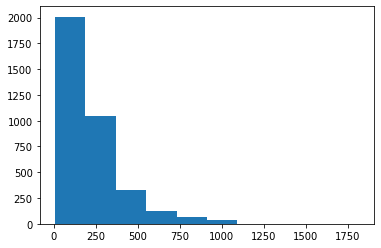

In [138]:
plt.hist(words_len_list);

In [139]:
max_words = int(np.quantile(words_len_list, q=0.95))+1 #most of the texts have less than 597 words
max_words

598

In [140]:
text_vectorizer = layers.TextVectorization(max_tokens= 100000, output_sequence_length= max_words )

In [141]:
text_vectorizer.adapt(x_train)

In [142]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence Vector : {text_vectorizer([sent])}
Vector length : {len(text_vectorizer([sent])[0])}
""")


Sentence length : 168
Sentence : A long time ago in a galaxy far far away sound familiar water has become the most precious commodity this has got to sound familiar and a small minority control its distribution what a surprise just have a heart attack and die from that surprise A group of ice pirates water renegadeswet banditsoh wait that last ones been used try to discover the route to a fabled unlimited supply of water with a lovely but spoiled Druish princess en tow and a group of idiotserdespicable villains in pursuitThis movie has the potential to be a really great comedic parody Star Wars David Lynchs Dune but was just not handled correctly It goes for I believe the term is low brow humor It doesnt really succeed in being all that funny which is a shame since it has Angelica Houston Ron Perlman and Robert Urich hence the three stars who arent exactly slackers in the acting departmentDefinitely a rental and definitely have a drink straight up
Sentence Vector : [[    3   213   

In [143]:
print(f"""
Number of the tokens : {len(text_vectorizer.get_vocabulary())}
Most common words : {  text_vectorizer.get_vocabulary()[:20]}
least common words {  text_vectorizer.get_vocabulary()[-20:]}
  """)


Number of the tokens : 45589
Most common words : ['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'with', 'for', 'movie', 'but', 'film']
least common words ['abductors', 'abducting', 'abduct', 'abdomen', 'abc\x85', 'abcs', 'abbas', 'ab', 'aavjo', 'aarons', 'aap', 'aamir', 'aake', 'aachen', 'aaargh', 'aaand', 'aaahhhhhhh', 'aaah', 'aaaaah', 'aaa']
  


Embding Layer

In [144]:
embed = layers.Embedding(
len(text_vectorizer.get_vocabulary()),
128,
mask_zero = True 
)

In [145]:
sent = random.choice(np.array(x_train))
print(f"""
Sentence length : {len(sent.split())}
Sentence : {sent}
Sentence emmbedings : {embed(text_vectorizer([sent]))}
shape : {embed(text_vectorizer([sent])).shape}
""")


Sentence length : 351
Sentence : In the midst of a documentary about his parents the filmmakers mother dies but he continues making the documentary discovering a story he did not anticipate The result is an absorbing drama that has the quality of fiction in the best sense of that word where a likable but unknowing narrator unwittingly privileges the audience The narrative thus has a double weave the story of the documentary and the story of the documentarymakerOur admiration is with the filmmaker not only for doggedly pursuing his story though it risks his entire notion of his parents relationship but also for never giving in to sensationalism or melodrama Although the stuff of Hollywood lurks in the details Doug Block treats the story as he would everyday life For those of us who have always speculated about our parents life before we came on the scene or after we arrived but while we were too self absorbed to notice they had a life independent of ourselves  Birch Street gives fair w

### DL Model1 : Conv1D

In [146]:
input = layers.Input((1,), dtype= tf.string)
text_vectors = text_vectorizer(input)
embedings = embed(text_vectors)
x = layers.Conv1D(filters = 64, kernel_size = 5 , padding = "same", activation= "relu") (embedings)
x = layers.GlobalAveragePooling1D() (x)
output = layers.Dense(1, activation="sigmoid") (x)

dl_model1 = tf.keras.models.Model(input, output)

In [147]:
dl_model1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 598)              0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 598, 128)          5835392   
                                                                 
 conv1d_6 (Conv1D)           (None, 598, 64)           41024     
                                                                 
 global_average_pooling1d_5   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65  

In [148]:
dl_model1.compile(
    loss = "binary_crossentropy",
    optimizer= "adam",
    metrics = "accuracy"
)

In [149]:
def checkpoint(model_name):
  return tf.keras.callbacks.ModelCheckpoint(("Experiments"+"/"+ model_name),save_best_only=True )

In [150]:
history1 = dl_model1.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d")])

Epoch 1/5
113/113 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.6128

113/113 [==============================] - 31s 265ms/step - loss: 0.6678 - accuracy: 0.6128 - val_loss: 0.5851 - val_accuracy: 0.7950
Epoch 2/5
113/113 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8678

113/113 [==============================] - 27s 234ms/step - loss: 0.3915 - accuracy: 0.8678 - val_loss: 0.3853 - val_accuracy: 0.8425
Epoch 3/5
113/113 [==============================] - ETA: 0s - loss: 0.1560 - accuracy: 0.9644

113/113 [==============================] - 26s 233ms/step - loss: 0.1560 - accuracy: 0.9644 - val_loss: 0.3593 - val_accuracy: 0.8500
Epoch 4/5
113/113 [==============================] - 27s 237ms/step - loss: 0.0671 - accuracy: 0.9894 - val_loss: 0.3849 - val_accuracy: 0.8500
Epoch 5/5
113/113 [==============================] - 25s 220ms/step - loss: 0.0325 - accuracy: 0.9975 - val_loss: 0.4072 - val_accuracy: 0.8500


In [158]:
dl_model1 = tf.keras.models.load_model("/content/Experiments/conv1d")

In [160]:
dl_model1.evaluate(valid)

13/13 [==============================] - 1s 73ms/step - loss: 0.3593 - accuracy: 0.8500


[0.3593018352985382, 0.8500000238418579]

In [161]:
preds = dl_model1.predict(test)

32/32 [==============================] - 2s 46ms/step


In [168]:
print(confusion_matrix(y_test, np.round(preds)))

[[424  98]
 [ 46 432]]


In [175]:
print( f"Acuracy : {(432+424) / len(y_test)}" )

Acuracy : 0.856


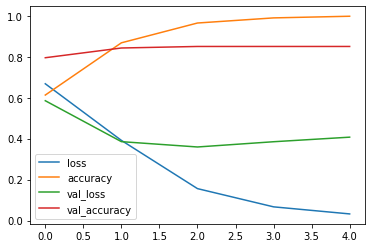

In [169]:
pd.DataFrame(history1.history).plot()

In [170]:
dl_model_1 = pd.DataFrame({"Train":[dl_model1.evaluate(train)[1]],"Validation": [dl_model1.evaluate(valid)[1]], "Test":[dl_model1.evaluate(test)[1]]} , index= ["DL Model 1 : Conv1D "])

32/32 [==============================] - 1s 39ms/step - loss: 0.3522 - accuracy: 0.8560


In [171]:
dl_model_1

,Train,Validation,Test
DL Model 1 : Conv1D,0.989444,0.85,0.856


I think I can train this models for more epochs

In [176]:
history1 = dl_model1.fit(train, 
                     epochs = 5,
                    validation_data = valid,
                     callbacks = [checkpoint("conv1d")])

Epoch 1/5
113/113 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9881

113/113 [==============================] - 31s 263ms/step - loss: 0.0659 - accuracy: 0.9881 - val_loss: 0.4016 - val_accuracy: 0.8475
Epoch 2/5
113/113 [==============================] - 25s 218ms/step - loss: 0.0281 - accuracy: 0.9958 - val_loss: 0.4358 - val_accuracy: 0.8475
Epoch 3/5
113/113 [==============================] - 24s 216ms/step - loss: 0.0142 - accuracy: 0.9994 - val_loss: 0.4769 - val_accuracy: 0.8475
Epoch 4/5
113/113 [==============================] - 25s 219ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.5290 - val_accuracy: 0.8400
Epoch 5/5
113/113 [==============================] - 25s 221ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.5559 - val_accuracy: 0.8400


In [111]:
dl_model1 = tf.keras.models.load_model("/content/Experimentsconv1d")

32/32 [==============================] - 2s 66ms/step - loss: 0.3472 - accuracy: 0.8600
